https://www.astroml.org/astroML-notebooks/chapter6/astroml_chapter6_Extreme_Deconvolution.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.stats import sigmaG

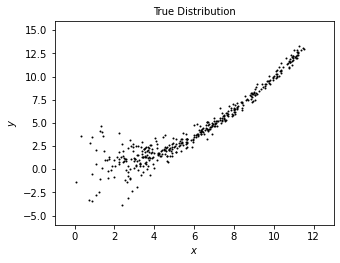

In [2]:
# Sample the dataset. 
# Here we use sample size = 400 in the example, 
# which converges in shorter time, and gives reasonable result.
N = 400
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# define a function to plot all distributions in the same format
def plot_distribution(text, sample_x, sample_y):
    plt.figure(figsize=(5, 3.75))
    plt.scatter(sample_x, sample_y, s=4,lw=0,c='k')
    plt.xlim(-1, 13)
    plt.ylim(-6, 16)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(text,fontsize=10)

# plot true distribution
plot_distribution('True Distribution', x_true, y_true)

plt.show()

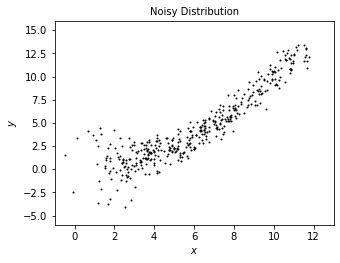

In [3]:
# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# plot noisy distribution
plot_distribution('Noisy Distribution', x, y)

In [4]:
# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

clf = XDGMM(n_components=10, max_iter=200)

clf.fit(X, Xerr)
sample = clf.sample(N)

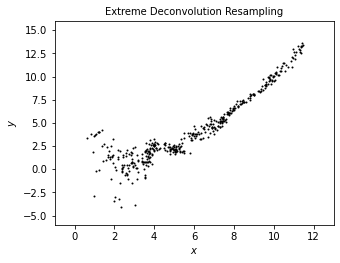

In [5]:
# plot noisy distribution
plot_distribution('Extreme Deconvolution Resampling', sample[:, 0], sample[:, 1])

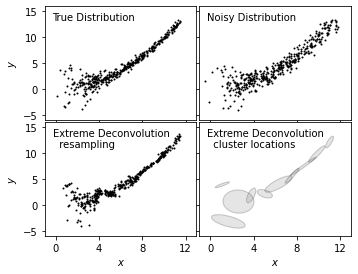

In [6]:
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')

In [7]:
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985 multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])

In [8]:
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]

downloading cross-matched SDSS/2MASS dataset from https://github.com/astroML/astroML-data/raw/main/datasets/stripe82calibStars_v2.6.dat.gz to /Users/zhiyuanguo/astroML_data
[=========================================]  63.58Mb / 63.58Mb   
uncompressing file...


In [9]:
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)



number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)


In [10]:
# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

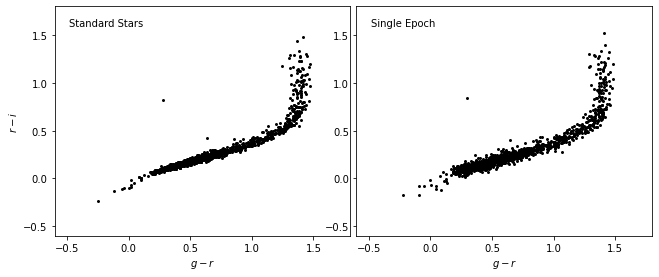

In [11]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(10, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(121)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')
ax1.set_ylabel('$r-i$')

ax2 = fig.add_subplot(122)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

titles = ["Standard Stars", "Single Epoch"]
ax = [ax1, ax2]

for i in range(2):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    ax[i].set_xlabel('$g-r$')

In [12]:
def compute_XD(n_clusters=12, rseed=0, max_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf

clf = compute_XD(12)

/Users/zhiyuanguo/opt/anaconda3/envs/astroml/lib/python3.10/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


1: log(L) = 32868
    (6.7 sec)
2: log(L) = 33422
    (7.3 sec)
3: log(L) = 33742
    (7.4 sec)
4: log(L) = 33967
    (7.2 sec)
5: log(L) = 34155
    (6.8 sec)
6: log(L) = 34307
    (6.6 sec)
7: log(L) = 34418
    (6.8 sec)
8: log(L) = 34507
    (7 sec)
9: log(L) = 34583
    (7.4 sec)
10: log(L) = 34648
    (6.8 sec)
11: log(L) = 34707
    (6.6 sec)
12: log(L) = 34762
    (6.7 sec)
13: log(L) = 34818
    (6.8 sec)
14: log(L) = 34884
    (6.6 sec)
15: log(L) = 34943
    (6.7 sec)
16: log(L) = 34988
    (7.2 sec)
17: log(L) = 35028
    (7.2 sec)
18: log(L) = 35066
    (7.3 sec)
19: log(L) = 35103
    (6.6 sec)
20: log(L) = 35138
    (6.8 sec)
21: log(L) = 35174
    (6.7 sec)
22: log(L) = 35208
    (6.6 sec)
23: log(L) = 35242
    (7.1 sec)
24: log(L) = 35276
    (6.6 sec)
25: log(L) = 35310
    (6.9 sec)
26: log(L) = 35342
    (6.6 sec)
27: log(L) = 35375
    (6.6 sec)
28: log(L) = 35406
    (6.6 sec)
29: log(L) = 35436
    (6.6 sec)
30: log(L) = 35465
    (6.6 sec)
31: log(L) = 35493
  

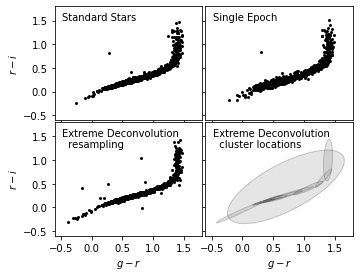

In [13]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')